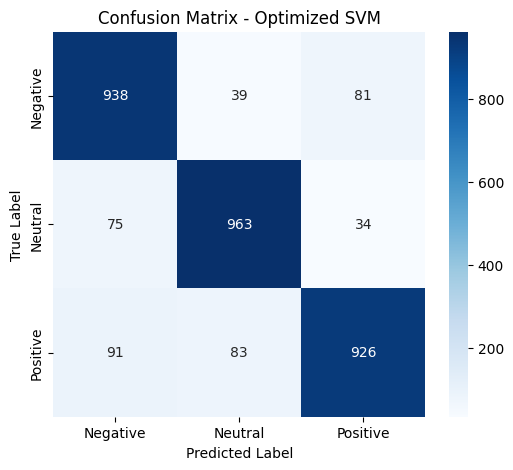

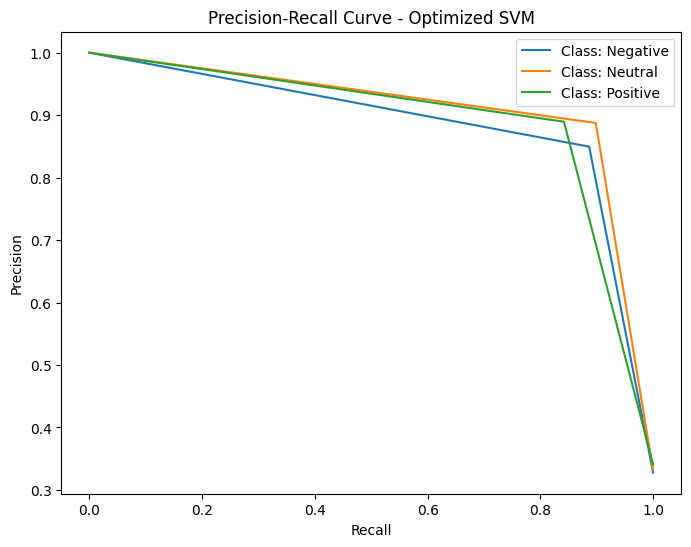

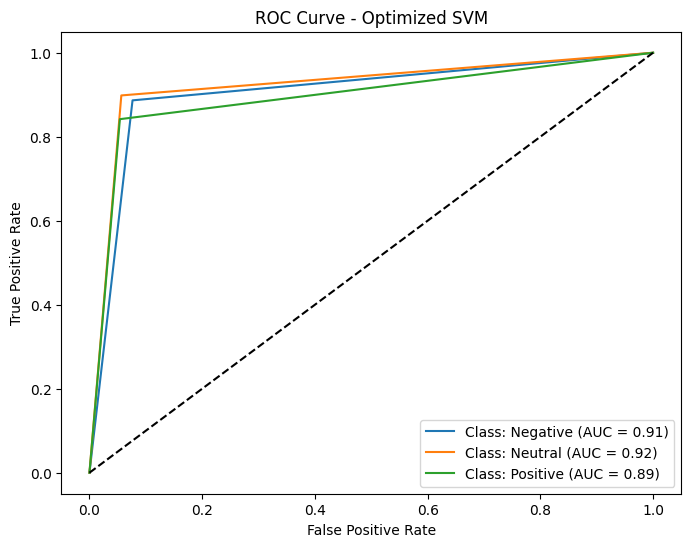

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Dessertation/sentiment_results.csv", encoding="latin1")

# Ensure text column exists and handle missing values
# If 'processed_text' column doesn't exist, create it and fill NaN with empty strings
if 'processed_text' not in df.columns:
    df['processed_text'] = df['text'].fillna("")  # Use raw text if preprocessing was lost
# If 'processed_text' column exists, fill NaN with empty strings
else:
    df['processed_text'] = df['processed_text'].fillna("")

# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
X_tfidf = vectorizer.fit_transform(df['processed_text'])

# Encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment_label'] = df['sentiment_label'].fillna("Neutral")  # Handle missing labels
y_encoded = label_encoder.fit_transform(df['sentiment_label'])

# Apply SMOTE to balance sentiment classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y_encoded)

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train optimized SVM model
svm_model = SVC(C=10, kernel='rbf', gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_best_svm = svm_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_best_svm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Optimized SVM")
plt.show()

# Compute Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for i, label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve((y_test == i).astype(int), (y_pred_best_svm == i).astype(int))
    plt.plot(recall, precision, label=f"Class: {label}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Optimized SVM")
plt.legend()
plt.show()

# Compute ROC Curve for each class
plt.figure(figsize=(8, 6))
for i, label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), (y_pred_best_svm == i).astype(int))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class: {label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Optimized SVM")
plt.legend()
plt.show()
